In [1]:
import os
import pandas as pd
import numpy as np
import time
import random as rd
import csv
import ta
import random
from pathlib import Path
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
from pprint import pprint
import seaborn as sns
import statsmodels.api as sma
import statsmodels.stats.outliers_influence  as smo
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import joblib

import sqlite_io as sio
import add_indicators as indic
import split_merge as sm
import balance
import model_mngr as modmgr

In [2]:
PATH_DATA = "C:\\Projets\\Data"
PATH_DB_FWK="C:\\Projets\\Data\\sqlite\\dataset_market.db"
PATH_DB_STOCK="C:\\Projets\\Data\\sqlite\\dataset_paris_stock_adjusted.db"
PATH_DATA_DTS=PATH_DATA+"\\DTS_FULL\\"


CONNECTION TO SQLITE

In [ ]:
if "con_stock" in locals():
        sio.close_connection(con_stock)
con_stock = sio.get_connection(str_db_path=PATH_DB_STOCK)

if "con_fwk" in locals():
        sio.close_connection(con_fwk)
con_fwk = sio.get_connection(str_db_path=PATH_DB_FWK)

my_session_maker = sessionmaker(bind=con_fwk)
session=my_session_maker()

table_stock="DS_PARIS_1D_ADJ_CLEAN"

GET DATA

In [ ]:
dts_name="PARIS_TREND_1D_20D_V1"
multi_symbol="PARIS_STOCK"

df_base=sio.get_candles_to_df(session=session,con=con_stock, target_table=table_stock)
df_work=pd.DataFrame()
for code_value in df_base.index.get_level_values('CODE').unique():
    sub_df=df_base[df_base.index.get_level_values('CODE') == code_value]
    df_work_tmp = indic.add_indicators_to_df(con=con_fwk, df_in=sub_df, dts_name=dts_name,symbol=multi_symbol)
    df_work = pd.concat([df_work, df_work_tmp])
    
df_work.sort_index(inplace=True)
df_work.info() 

In [ ]:
# df_work[10000:10010]
# pd.set_option('display.max_columns', None)
# print(df_work.describe())

# df_work.round(5).to_csv(
    PATH_DATA_DTS+"PARIS_TREND_1D_20D_V1_BASE.zip", sep=",")

In [ ]:
dts_name="PARIS_TREND_1D_20D_V1"
# dts_name="PARIS_TREND_1D_50D_V1"
multi_symbol="PARIS_STOCK"

df_work=pd.read_csv(PATH_DATA_DTS+dts_name+"_BASE.zip",sep=",",index_col=["OPEN_DATETIME","CODE"],parse_dates=["OPEN_DATETIME"])
df_work.head(5)

Check Dataframe

In [ ]:
df_check=df_work[df_work['stdev20_1d'] > 1000]
# df_check=df_check[df_check['ret_1d'] <= 2]
df_check.index.get_level_values('CODE').unique()
# df_check[df_check.index.get_level_values('CODE')=='AKW.PA']
# df_check=df_work[df_work.index.get_level_values('CODE')=='AI.PA']
# CATG
mask = df_work['stdev20_1d'] > 1000
df_work.drop(df_work[mask].index, inplace=True)
# df_check[6000:6010]


In [ ]:
df_work = indic.drop_indicators_by_type(
    con=con_fwk, df_in=df_work, dts_name=dts_name, symbol=multi_symbol, ind_type=0)
list_label = indic.get_ind_list_by_type_for_dts(
    con=con_fwk, dts_name=dts_name, symbol_code=multi_symbol, ind_type=2)
print(list_label)

In [ ]:
df_work=df_work.droplevel('CODE')
df_work.sort_index(inplace=True)
df_work.head(5)

In [ ]:
lab_studied = "lab_perf_50d"
algo_studied = "XG_BOOST_CLASS"
dts_name="PARIS_TREND_1D_50D_V1"

df_work_lab = indic.drop_indicators_not_selected(con=con_fwk, df_in=df_work, dts_name=dts_name, symbol=multi_symbol,label=lab_studied,algo=algo_studied)

df_split=sm.split_df_by_label_strat(
    df_in=df_work_lab, list_label=[lab_studied], split_timeframe="M",random_split=False,split_strat=(80,10,10))
df_selected = df_split['df_'+lab_studied+'_train']
df_valid = df_split['df_'+lab_studied+'_valid']
df_confirm = df_split['df_'+lab_studied+'_confirm']
df_selected.sort_index(inplace=True)
df_valid.sort_index(inplace=True)
df_confirm.sort_index(inplace=True)

print(f"selected: {df_selected.shape=} valid: {df_valid.shape=} confirm: {df_confirm.shape=}")


In [ ]:
label=lab_studied
df_class=balance.add_class_by_lab_nb_lines(df_in=df_selected,str_label=lab_studied,nb_class=5,bool_replace_label=False)
min_max_lab_by_class = df_class.groupby(label+'_class')[label].agg(['min', 'max'])
print(min_max_lab_by_class)

In [ ]:
label=lab_studied
df_class=balance.add_class_by_lab_nb_lines(df_in=df_selected,str_label=lab_studied,nb_class=5,bool_replace_label=True)
df_class.sort_index(inplace=True)
categ_50={0:[-1,-0.07876],1:[-0.07876,-0.00783],2:[-0.00783,0.04790],3:[0.04790,0.12406],4:[0.12406,6]}
categ_20={0:[-1,-0.05172],1:[-0.05172,-0.00868],2:[-0.00868,0.02272],3:[0.02272,0.07058],4:[0.07059,5]}
df_class_val=balance.add_lab_by_class(df_in=df_valid,str_label=lab_studied, categ=categ_50,bool_replace_label=True) # categ
df_class_val.sort_index(inplace=True)
df_class_conf=balance.add_lab_by_class(df_in=df_confirm,str_label=lab_studied, categ=categ_50,bool_replace_label=True) # categ
df_class_conf.sort_index(inplace=True)
print(df_class.loc[:, label].dropna().iloc[[0, -1]])
print(df_class_val.loc[:, label].dropna().iloc[[0, -1]])
print(df_class_conf.loc[:, label].dropna().iloc[[0, -1]])
# df_class_clean=df_class.drop(['OPEN','HIGH','LOW','CLOSE','VOLUME','lab_perf_125d','lab_perf_20d','lab_perf_50d'],axis=1)
data = df_class[label]
print(data.value_counts().sort_index())
data_val = df_class_val[label]
print(data_val.value_counts().sort_index())
data_conf = df_class_conf[label]
print(data_conf.value_counts().sort_index())
# min_max_lab_by_class = df_class.groupby(label+'_class')[label].agg(['min', 'max'])
# print(min_max_lab_by_class)

#                         min      max
# lab_perf_20d_class                  
# 0                  -0.87743 -0.05172
# 1                  -0.05171 -0.00868
# 2                  -0.00867  0.02272
# 3                   0.02273  0.07058
# 4                   0.07059  3.82176

In [ ]:
list_feat = df_class.columns.values.tolist()
list_feat.remove(label)
df_x_train, col_y_train = sm.split_df_x_y(
    df_in=df_class, list_features=list_feat, str_label=label, drop_na=True)
df_x_val, col_y_val = sm.split_df_x_y(
    df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)
df_x_conf, col_y_conf = sm.split_df_x_y(
    df_in=df_class_conf, list_features=list_feat, str_label=label, drop_na=True)

df_class.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_50D_V1_TRAIN.zip", sep=",")
df_class_val.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_50D_V1_VAL.zip", sep=",")
df_class_conf.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_50D_V1_CONF.zip", sep=",")

In [3]:
dts_name="PARIS_TREND_1D_50D_V1"
multi_symbol="PARIS_STOCK"
label = "lab_perf_50d"

df_class=pd.read_csv(PATH_DATA_DTS+dts_name+"_TRAIN.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class.dropna(subset=[label], inplace=True)
df_class.sort_index(inplace=True)
df_class_val=pd.read_csv(PATH_DATA_DTS+dts_name+"_VAL.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class_val.dropna(subset=[label], inplace=True)
df_class_val.sort_index(inplace=True)

list_feat = df_class.columns.values.tolist()
list_feat.remove(label)
X, y = sm.split_df_x_y(
    df_in=df_class, list_features=list_feat, str_label=label, drop_na=True)
nb_val=188000
method = RandomUnderSampler(sampling_strategy={0:nb_val,1:nb_val,2:nb_val,3:nb_val,4:nb_val}) # 47000 pour lab 20 et 45000 pour lab 50
df_x_train, col_y_train=  method.fit_resample(X, y)
print(col_y_train.value_counts().sort_index())

X, y = sm.split_df_x_y(
    df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)
# X = df_class_val.drop(label, axis=1, inplace=False)
# y = df_class_val[label]
nb_val=45000
method = RandomUnderSampler(sampling_strategy={0:nb_val,1:nb_val,2:nb_val,3:nb_val,4:nb_val}) # 47000 pour lab 20 et 45000 pour lab 50
df_x_val, col_y_val=  method.fit_resample(X, y)
print(col_y_val.value_counts().sort_index())
# df_x_val, col_y_val = sm.split_df_x_y(
    # df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)

lab_perf_50d
0    188000
1    188000
2    188000
3    188000
4    188000
Name: count, dtype: int64
lab_perf_50d
0.0    45000
1.0    45000
2.0    45000
3.0    45000
4.0    45000
Name: count, dtype: int64


Correlation

In [ ]:
corr_train = df_x_train.corr()
fig, ax = plt.subplots(figsize=(6, 6))
corr_train.replace(1,0,inplace=True)
corr_train=corr_train.applymap(lambda x : None if x< 0.8 and x>-0.8 else x)
corr_train.dropna(axis=0,how='all',inplace=True)
corr_train.dropna(axis=1,how='all',inplace=True)

corr_train_check=corr_train[corr_train >0.8]
corr_train_check.head()
sns.heatmap(corr_train_check, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)


In [ ]:
df_x_train_VIF = sma.add_constant(df_x_train)
vif = pd.DataFrame()
vif["feature"]=df_x_train_VIF.columns
vif["VIF"]= [smo.variance_inflation_factor(df_x_train_VIF.values, i) for i in range(df_x_train_VIF.shape[1])]
print(vif)

In [ ]:
rnd_key=28
n_jobs=3

df_usamp=df_x_train[:300000]
print(f"{df_usamp.shape=}")
df_x_boruta, col_y_boruta = sm.split_df_x_y(
    df_in=df_usamp, list_features=list_feat, str_label=label, drop_na=True)

rf_bo = RandomForestClassifier(n_estimators=100, n_jobs=n_jobs)
boruta_selector = BorutaPy(rf_bo, n_estimators='auto',
                           verbose=1, random_state=int(rnd_key))
boruta_selector.fit(df_x_boruta.values, col_y_boruta.values)
selected_features = df_x_boruta.columns[boruta_selector.support_]
print(selected_features)

not_selected_features = set(df_x_boruta.columns) - set(selected_features)
print(not_selected_features)

XGBoost

In [17]:
# pd.set_option('display.max_columns', None)
# print(df_x_train.describe())

print(f"{df_x_train.shape=} {df_x_val.shape=} {col_y_train.size=} {col_y_val.size=}")


col_y_train_int = col_y_train.to_numpy().astype(int)
col_y_val_int = col_y_val.to_numpy().astype(int)
nb_class = np.unique(col_y_train_int).size



df_x_train.shape=(940000, 18) df_x_val.shape=(225000, 18) col_y_train.size=940000 col_y_val.size=225000
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)


In [ ]:
rnd_key=28
n_jobs=2

col_y_train_int = col_y_train.to_numpy().astype(int)
col_y_val_int = col_y_val.to_numpy().astype(int)

nb_class = np.unique(col_y_train_int).size

# Convert target variables into binary matrix representation
# encoder = OneHotEncoder()
# col_y_train_encoded = encoder.fit_transform(col_y_train_int.reshape(-1, 1)).toarray()
# col_y_val_encoded = encoder.transform(col_y_val_int.reshape(-1, 1)).toarray()

time_split = TimeSeriesSplit(n_splits=5)

eval_set=[(df_x_val, col_y_val_int)]

print(f"{df_x_train.shape=} {df_x_val.shape=} {col_y_train_int.shape=} {col_y_val_int.shape=} {nb_class=}")

scoring = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'precision_weighted': metrics.make_scorer(metrics.precision_score, average='weighted'),
    'recall_weighted': metrics.make_scorer(metrics.recall_score, average='weighted'),
    'f1_weighted': metrics.make_scorer(metrics.f1_score, average='weighted')
}

grid = {
    # default 1 subsample ratio of columns when constructing each tree
    # "colsample_bytree": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    # "colsample_bylevel": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    # "colsample_bynode": [x for x in np.linspace(0.5, 1.0, num=6, endpoint=True)],
    # default 0 minimum loss reduction to make a further patition on a leaf [x for x in np.linspace(0, 0.1, num=2, endpoint=True)]
    "gamma": [0],
    # [x for x in np.linspace(0.01, 0.3, num=8, endpoint=True)],  # default 0.1 [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "learning_rate": [0.1],
    # default 6 max depth of the tree 
    "max_depth": [int(x) for x in np.linspace(5, 7, num=3, endpoint=True, dtype=int)],
    # default 100
    "n_estimators": [int(x) for x in np.linspace(start=20, stop=60, num=3, endpoint=True, dtype=int)],
    # default 1 subsample ratio of the training instances
    # [x for x in np.linspace(0.6, 1.0, num=3, endpoint=True)],[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    "subsample": [1.0],
    # default 1 minimum sum of instance weight needed in a child
    # "min_child_weight": [x for x in np.linspace(0.5, 3, num=6, endpoint=True)],
    # default 0 Maximum delta step we allow each leaf output to be.
    "max_delta_step": [0]
    # default 1 L2 regularization term on weights. Increasing this value will make model more conservative.
    #"lambda": [0.5, 1, 1.5, 2],
    # default 0 L1 regularization term on weights. Increasing this value will make model more conservative.
    #"alpha": [0, 0.25, 0.5, 0.75, 1, 1.5, 2]

}



xgb_class = xgb.XGBClassifier(objective='multi:softmax', num_class=nb_class, early_stopping_rounds=5,eval_metric='merror')#

# xgb_class = xgb.XGBClassifier(enable_categorical=True, tree_method='hist')#
#18min pour 1 cas
xgb_fitted = modmgr.search_cv_fit_report(estimator=xgb_class, params=grid,
                                         x_train=df_x_train, y_train=col_y_train_int,cv=time_split,eval_set=eval_set,
                                           n_iter=20, n_top=10, method='grid', scoring=scoring, refit='precision_weighted',n_jobs=n_jobs)
# from sklearn.model_selection import  GridSearchCV
# print(xgb_class)
# xgb_fitted = GridSearchCV(estimator=xgb_class,
#                               param_grid=grid,
#                               cv=time_split,
#                               n_jobs=n_jobs, scoring=scoring, error_score='raise', refit='precision_weighted')

# xgb_fitted.fit(df_x_train, col_y_train_int,eval_set=eval_set)

mean_test_precision_weighted = xgb_fitted.cv_results_['mean_test_precision_weighted']
params=xgb_fitted.cv_results_['params']

ranked=np.argsort(-mean_test_precision_weighted)

for rank,score_idx in enumerate(ranked):
    if rank<20:
        params_str = ', '.join(f"{param}: {value}" for param, value in params[score_idx].items())
        print(f"Rank {rank+1}: mean_test_precision_weighted {mean_test_precision_weighted[score_idx]:.4f}, Parameters: {params_str}")


[0]	validation_0-mlogloss:1.60465
[1]	validation_0-mlogloss:1.60056
[2]	validation_0-mlogloss:1.59701
[3]	validation_0-mlogloss:1.59397
[4]	validation_0-mlogloss:1.59125
[5]	validation_0-mlogloss:1.58888
[6]	validation_0-mlogloss:1.58686
[7]	validation_0-mlogloss:1.58504
[8]	validation_0-mlogloss:1.58361
[9]	validation_0-mlogloss:1.58227
[10]	validation_0-mlogloss:1.58113
[11]	validation_0-mlogloss:1.58019
[12]	validation_0-mlogloss:1.57943
[13]	validation_0-mlogloss:1.57857
[14]	validation_0-mlogloss:1.57796
[15]	validation_0-mlogloss:1.57747
[16]	validation_0-mlogloss:1.57707
[17]	validation_0-mlogloss:1.57672
[18]	validation_0-mlogloss:1.57634
[19]	validation_0-mlogloss:1.57602
[20]	validation_0-mlogloss:1.57575
[21]	validation_0-mlogloss:1.57552
[22]	validation_0-mlogloss:1.57527
[23]	validation_0-mlogloss:1.57503
[24]	validation_0-mlogloss:1.57495
[25]	validation_0-mlogloss:1.57473
[26]	validation_0-mlogloss:1.57466
[27]	validation_0-mlogloss:1.57466
[28]	validation_0-mlogloss:1.5

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

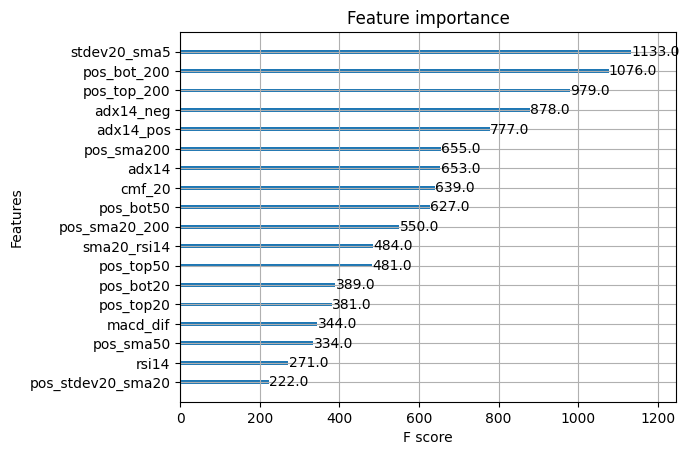

In [23]:
rnd_key=28
params={'gamma':0,'subsample': 1.0, 'n_estimators': 40, 'max_depth': 6, 'learning_rate': 0.1, 'max_delta_step':0}

col_y_train_int = col_y_train.to_numpy().astype(int)
col_y_val_int = col_y_val.to_numpy().astype(int)


eval_set=[(df_x_val, col_y_val_int)]

objective='multi:softprob' # multi:softmax multi:softproba enable_categorical=True, tree_method='hist'

xgb_class = xgb.XGBClassifier(objective=objective,num_class=5, early_stopping_rounds=5, random_state=int(rnd_key),
                           learning_rate=params['learning_rate'], subsample=params['subsample'], gamma=params['gamma'],max_delta_step=params['max_delta_step'],
                        #    colsample_bytree=params['colsample_bytree'],#colsample_bynode= 0.5, colsample_bylevel= 0.5, 
                            # min_child_weight=params['min_child_weight'],
                            max_depth=params['max_depth'], n_estimators=params['n_estimators'], verbosity=1)

xgb_class.fit(df_x_train, col_y_train_int,eval_set=eval_set)

print(f"Accuracy XGBoost classifier Training score : {xgb_class.score(df_x_train, col_y_train_int)}")

#y_pred_valid = xgb_reg.predict(df_x_valid)

print(
    f"Accuracy XGBoost classifier Validation score :{xgb_class.score(df_x_val, col_y_val_int)}")

# print(xgb_reg.feature_importances_)
xgb.plot_importance(xgb_class)


In [ ]:
rnd_key=28
params={'gamma':0,'subsample': 1.0, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.1, 'max_delta_step':0, 'min_child_weight':1.5}

col_y_train_int = col_y_train.to_numpy().astype(int)
col_y_val_int = col_y_val.to_numpy().astype(int)

eval_set=[(df_x_val, col_y_val_int)]

objective='multi:softprob' # multi:softmax multi:softproba

xgb_class = xgb.XGBClassifier(objective=objective, num_class=5,early_stopping_rounds=5,eval_metric='merror', random_state=int(rnd_key),
                           learning_rate=params['learning_rate'], subsample=params['subsample'], gamma=params['gamma'],max_delta_step=params['max_delta_step'],
                        #    colsample_bytree=params['colsample_bytree'],#colsample_bynode= 0.5, colsample_bylevel= 0.5, 
                            min_child_weight=params['min_child_weight'],
                            max_depth=params['max_depth'], n_estimators=params['n_estimators'], verbosity=1)

xgb_class.fit(df_x_train, col_y_train_int,eval_set=eval_set)

print(f"Accuracy XGBoost classifier Training score : {xgb_class.score(df_x_train, col_y_train_int)}")

#y_pred_valid = xgb_reg.predict(df_x_valid)

print(
    f"Accuracy XGBoost classifier Validation score :{xgb_class.score(df_x_val, col_y_val_int)}")

# print(xgb_reg.feature_importances_)
xgb.plot_importance(xgb_class)


In [ ]:
y_pred = xgb_class.predict(df_x_val)

conf_matrix = metrics.confusion_matrix(col_y_val_encoded, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=range(conf_matrix.shape[1]), 
            yticklabels=range(conf_matrix.shape[0]))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred_proba = xgb_class.predict_proba(df_x_val)
print(y_pred_proba)

PATH_MODEL = "../../../Data/Models/"
ext_pkl = ".pkl"
xgb_suffix = "_xgb_class"
joblib.dump(xgb_class, PATH_MODEL+"PARIS_TREND_1D_50D_V1_"+label+xgb_suffix+ext_pkl)

Load DF and models to generate backtest files

In [ ]:
dts_name="PARIS_TREND_1D_50D_V1"  #UPDATE
multi_symbol="PARIS_STOCK"
label = "lab_perf_50d"   #UPDATE
PATH_MODEL = "../../../Data/Models/"
ext_pkl = ".pkl"
xgb_suffix = "_xgb_class"

df_class_val=pd.read_csv(PATH_DATA_DTS+dts_name+"_VAL.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class_val.dropna(subset=[label], inplace=True)
df_class_val.sort_index(inplace=True)
df_class_conf=pd.read_csv(PATH_DATA_DTS+dts_name+"_CONF.zip",sep=",",index_col=["OPEN_DATETIME"],parse_dates=["OPEN_DATETIME"])
df_class_conf.dropna(subset=[label], inplace=True)
df_class_conf.sort_index(inplace=True)

list_feat = df_class_val.columns.values.tolist()
list_feat.remove(label)

# df_x_val, col_y_val = sm.split_df_x_y(
#     df_in=df_class_val, list_features=list_feat, str_label=label, drop_na=True)
# print(df_class_val.value_counts().sort_index())


# df_x_conf, col_y_conf = sm.split_df_x_y(
#     df_in=df_class_conf, list_features=list_feat, str_label=label, drop_na=True)
# print(df_class_conf.value_counts().sort_index())

xgb_class=joblib.load(PATH_MODEL+dts_name+"_"+label+xgb_suffix+ext_pkl)
col="predict_"+label
df_class_val[col] = xgb_class.predict(df_class_val[list_feat])
proba = xgb_class.predict_proba(df_class_val[list_feat])
df_class_val[col+"_proba"] = proba.tolist()
df_class_conf[col] = xgb_class.predict(df_class_conf[list_feat])
proba = xgb_class.predict_proba(df_class_conf[list_feat])
df_class_conf[col+"_proba"] = proba.tolist()

print(df_class_conf.head(5))

if label=="lab_perf_50d":
    df_class_valconf_50d = pd.concat([df_class_val, df_class_conf])        
if label=="lab_perf_20d":
    df_class_valconf_20d = pd.concat([df_class_val, df_class_conf])        




In [ ]:
df_class_valconf_20d.head(5)

In [ ]:
df_base=pd.read_csv(PATH_DATA_DTS+"PARIS_TREND_1D_20D_V1_BASE.zip",sep=",",index_col=["OPEN_DATETIME","CODE"],parse_dates=["OPEN_DATETIME"])
df_base.head(5)

In [9]:

df_base.reset_index(inplace=True)  # Reset the index
df_base.drop_duplicates(subset=['OPEN_DATETIME', 'pos_sma50', 'pos_sma200', 'rsi14', 'pos_top_200', 'pos_bot_200'], inplace=True)
merged_df = df_base.merge(df_class_valconf_20d, on=['OPEN_DATETIME', 'pos_sma50', 'pos_sma200', 'rsi14', 'pos_top_200','pos_bot_200'], how='inner',suffixes=[None,"_merge20d"],validate="one_to_one")
merged_df = merged_df.merge(df_class_valconf_50d, on=['OPEN_DATETIME', 'pos_sma50', 'pos_sma200', 'rsi14', 'pos_top_200','pos_bot_200'], how='inner',suffixes=[None,"_merge50d"],validate="one_to_one")
merged_df = merged_df.drop(columns=merged_df.filter(like='_merge20d').columns)
merged_df = merged_df.drop(columns=merged_df.filter(like='_merge50d').columns)
merged_df.dropna(subset=['predict_lab_perf_20d', 'predict_lab_perf_50d'], inplace=True)

merged_df.describe()



,OPEN_DATETIME,OPEN,HIGH,LOW,CLOSE,VOLUME,sma20,pos_sma20,sma50,sma200,...,pos_donchian20_lo,adx14,adx14_neg,adx14_pos,adx14_dif,avg_vol14,pos_avg_vol14,pos_sma20_200,predict_lab_perf_20d,predict_lab_perf_50d
count,535117,535117.000000,535117.000000,535117.000000,535117.000000,5.351170e+05,535117.000000,535117.000000,5.351170e+05,5.351170e+05,...,535117.000000,535117.000000,535117.000000,535117.000000,535117.000000,5.351170e+05,535117.000000,535117.000000,535117.000000,535117.000000
mean,2020-08-01 20:24:34.318326528,109.231074,111.211909,106.628116,108.664436,3.125364e+05,114.659320,-0.000042,1.575204e+02,5.875657e+02,...,0.082884,26.833415,25.706156,25.444846,-0.261310,3.119480e+05,1.024634,0.011940,1.781898,1.679962
min,2017-03-01 00:00:00,0.001800,0.001800,0.001600,0.001700,0.000000e+00,0.002710,-0.888000,5.230000e-03,1.443000e-02,...,0.000000,4.060900,0.000000,0.000000,-99.999940,5.000000e-02,0.000000,-0.997110,0.000000,0.000000
25%,2018-11-30 00:00:00,10.432600,10.578300,10.251200,10.412400,8.670000e+02,10.473080,-0.026270,1.054610e+01,1.074755e+01,...,0.024480,17.948170,17.616970,17.424930,-11.243850,1.514400e+03,0.442070,-0.081100,0.000000,0.000000
50%,2020-08-19 00:00:00,26.250000,26.554800,25.903300,26.218300,1.159700e+04,26.246940,0.000240,2.627194e+01,2.604925e+01,...,0.054470,24.133990,23.459260,23.278940,-0.309400,1.446735e+04,0.779520,0.013610,2.000000,2.000000
75%,2022-04-07 00:00:00,66.453800,67.126400,65.646900,66.428100,1.228270e+05,66.335500,0.026450,6.627078e+01,6.514756e+01,...,0.103000,32.953720,30.863950,30.463230,10.651460,1.330422e+05,1.188150,0.101660,3.000000,3.000000
max,2023-11-01 00:00:00,299711.812500,319884.718800,244956.765600,279538.906300,4.655171e+08,450864.555480,5.659640,1.527032e+06,3.983415e+06,...,10.396180,99.999340,99.999970,100.000000,100.000000,1.406648e+08,20.000000,4.488220,4.000000,4.000000
std,NaN,1962.747415,2073.960294,1815.080755,1921.684186,1.739509e+06,2402.182486,0.068476,7.495128e+03,3.260570e+04,...,0.121988,12.247420,12.370430,12.538963,19.369981,1.342523e+06,1.232201,0.197609,1.520931,1.473761


In [10]:
merged_df.dropna(subset=['predict_lab_perf_20d', 'predict_lab_perf_50d'], inplace=True)
categ_50={0:[-1,-0.07876],1:[-0.07876,-0.00783],2:[-0.00783,0.04790],3:[0.04790,0.12406],4:[0.12406,6]}
categ_20={0:[-1,-0.05172],1:[-0.05172,-0.00868],2:[-0.00868,0.02272],3:[0.02272,0.07058],4:[0.07059,5]}
merged_df=balance.add_lab_by_class(df_in=merged_df,str_label='lab_perf_20d', categ=categ_20,bool_replace_label=True) 
merged_df=balance.add_lab_by_class(df_in=merged_df,str_label='lab_perf_50d', categ=categ_50,bool_replace_label=True) 
merged_df.sort_index(inplace=True)
merged_df['lab_perf_50d_20d'] = merged_df['lab_perf_50d'].astype(int).astype(str) + merged_df['lab_perf_20d'].astype(int).astype(str)
merged_df['predict_lab_perf_50d_20d'] = merged_df['predict_lab_perf_50d'].astype(str) + merged_df['predict_lab_perf_20d'].astype(str)

merged_df.head(5)

,OPEN_DATETIME,CODE,OPEN,HIGH,LOW,CLOSE,VOLUME,sma20,pos_sma20,sma50,...,pos_avg_vol14,pos_sma20_200,predict_lab_perf_20d,predict_lab_perf_20d_proba,predict_lab_perf_50d,predict_lab_perf_50d_proba,lab_perf_20d,lab_perf_50d,lab_perf_50d_20d,predict_lab_perf_50d_20d
0,2017-03-01,AAA.PA,0.7935,0.7935,0.7935,0.7935,175.0,0.83465,-0.04930,0.73080,...,1.49317,0.17094,0,"[0.30191418528556824, 0.15592798590660095, 0.1...",4,"[0.22611837089061737, 0.15073952078819275, 0.1...",0.0,0.0,00,40
1,2017-03-02,AAA.PA,0.7935,0.7935,0.7935,0.7935,0.0,0.83068,-0.04476,0.73774,...,0.00000,0.16765,4,"[0.25725823640823364, 0.1404629796743393, 0.19...",4,"[0.22611837089061737, 0.15073952078819275, 0.1...",0.0,0.0,00,44
2,2017-03-03,AAA.PA,0.7836,0.7836,0.7141,0.7141,2025.0,0.82275,-0.13206,0.74310,...,13.30486,0.15941,4,"[0.2254568636417389, 0.16570019721984863, 0.15...",4,"[0.2176273912191391, 0.1454811990261078, 0.146...",0.0,1.0,10,44
3,2017-03-06,AAA.PA,0.7141,0.7141,0.7141,0.7141,0.0,0.81878,-0.12785,0.74845,...,0.00000,0.15673,4,"[0.1720595508813858, 0.11269152909517288, 0.13...",4,"[0.22265689074993134, 0.15914469957351685, 0.1...",0.0,1.0,10,44
4,2017-03-07,AAA.PA,0.7141,0.7141,0.7141,0.7141,0.0,0.81233,-0.12092,0.75381,...,0.00000,0.15011,4,"[0.18273396790027618, 0.11898792535066605, 0.1...",4,"[0.22525662183761597, 0.1581164002418518, 0.15...",0.0,1.0,10,44


In [ ]:
merged_df_save=merged_df[['OPEN_DATETIME','CODE','CLOSE','pos_sma200','stdev20_sma5','pos_bot_200','pos_top_200','adx14_pos','lab_perf_50d_20d','predict_lab_perf_50d_20d','predict_lab_perf_20d_proba','predict_lab_perf_50d_proba']]
merged_df_save_filtered = merged_df_save[merged_df_save['predict_lab_perf_50d_20d'].isin(["44", "43", "34"])]
merged_df_light=merged_df[['OPEN_DATETIME','CODE','CLOSE','predict_lab_perf_50d_20d']]
merged_df_save_filtered.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_XGB_20D_50D_V1_FILTERED.zip", sep=",")
merged_df_light.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_XGB_20D_50D_V1_FULL.zip", sep=",")

In [12]:
merged_df_bt_save=merged_df[['OPEN_DATETIME','CODE','OPEN','HIGH','LOW','CLOSE','pos_sma200','adx14_pos','lab_perf_50d_20d','predict_lab_perf_50d_20d']]
merged_df_bt_save.round(5).to_csv(
    PATH_DATA+"\DTS_FULL\PARIS_TREND_1D_XGB_20D_50D_V1_BT.zip", sep=",")